In [1]:
## 기본 라이브러리
import re
import warnings
import numpy as np
import pandas as pd

## 시각화 라이브러리
import matplotlib
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
from matplotlib import patches
import seaborn as sns
import chart_studio
import chart_studio.plotly as py
import plotly.express as px
import plotly.graph_objects as go
from chart_studio.plotly import plot, iplot
chart_studio.tools.set_credentials_file(username='dr.jeong9320', api_key='ggw0NGVO6S8rS9mrbNCr')

## 통계 라이브러리
import scipy.stats as stats
from scipy.special import boxcox1p
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

## 설정
warnings.filterwarnings('ignore')
pd.set_option("display.max_columns", 200)
pd.set_option("display.max_rows", 500)

## Matplotlib 한글 폰트 설정
fm.get_fontconfig_fonts()
# font_location = '/usr/share/fonts/truetype/nanum/NanumGothicOTF.ttf'
font_location = 'C:/Windows/Fonts/gulim.ttc' # For Windows
font_name = fm.FontProperties(fname=font_location).get_name()
matplotlib.rc('font', family=font_name)
plt.rc('figure', titlesize=70)

%matplotlib inline

# Data Load

  Dacon에서 "KBO 타자 OPS 예측 대회"에서 제공한 데이터셋과 KBO 기록 사이트인 스탯티즈에서 연도별 타자들의 기록을 수집한 데이터를 결합한 데이터셋을 사용하였다.  
  1. Regular_Season_Batter.csv: 연도별 정규 시즌 통합 데이터셋으로, Dacon 제공 데이터셋과 스탯티즈에서 크롤링한 데이터를 병합하였다.

In [2]:
rsb = pd.read_csv('./data/Regular_Season_Batter.csv') # 정규시즌 + 스탯티즈 크롤링 데이터
# psb = pd.read_csv('./data/Pre_Season_Batter.csv') # 프리시즌
# rsbd = pd.read_csv('./data/Regular_Season_Batter_Day_by_Day.csv') # 정규시즌 매경기 기록

In [3]:
# 과거 팀명 변경
rsb.loc[rsb['team'].isin(['현대', '우리', '넥센', '키움']), 'team'] = '히어로즈'
rsb.loc[rsb['team'].isin(['OB']), 'team'] = '두산'
rsb.loc[rsb['team'].isin(['쌍방울']), 'team'] = 'SK'
rsb.loc[rsb['team'].isin(['해태']), 'team'] = 'KIA'

In [4]:
rsb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2454 entries, 0 to 2453
Data columns (total 35 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   batter_id    2454 non-null   int64  
 1   batter_name  2454 non-null   object 
 2   year         2454 non-null   float64
 3   age          2454 non-null   int64  
 4   position     2289 non-null   object 
 5   team         2454 non-null   object 
 6   career       2454 non-null   object 
 7   G            2454 non-null   int64  
 8   E            2454 non-null   int64  
 9   PA           2445 non-null   float64
 10  AB           2454 non-null   int64  
 11  R            2454 non-null   int64  
 12  H            2454 non-null   int64  
 13  2B           2454 non-null   int64  
 14  3B           2454 non-null   int64  
 15  HR           2454 non-null   int64  
 16  TB           2454 non-null   int64  
 17  RBI          2454 non-null   int64  
 18  SB           2454 non-null   int64  
 19  CS    

In [5]:
rsb.describe()

,batter_id,year,age,G,E,PA,AB,R,H,2B,3B,HR,TB,RBI,SB,CS,BB,HBP,IBB,SO,GDP,SH,SF,avg,OBP,SLG,OPS,wOBA,wRC,WAR,WPA
count,2454.000000,2454.000000,2454.000000,2454.000000,2454.000000,2445.000000,2454.000000,2454.000000,2454.000000,2454.000000,2454.000000,2454.000000,2454.000000,2454.000000,2454.000000,2454.000000,2454.000000,2454.000000,2445.000000,2454.000000,2454.000000,2445.000000,2445.000000,2428.000000,2431.000000,2428.000000,2454.000000,2422.000000,2389.000000,2432.000000,1040.000000
mean,178.079462,2011.614507,27.104319,72.534230,3.676447,230.713292,201.513447,29.911980,55.988590,9.863896,0.957213,5.504075,84.279136,27.789731,5.289731,2.335778,20.943765,3.424613,0.778732,38.596170,4.603504,3.384049,1.806953,0.237566,0.306699,0.344890,0.644243,0.296642,70.802637,1.108890,0.528010
std,97.557947,4.992833,4.686211,45.094061,4.585248,194.775499,169.536433,28.778864,52.253551,9.871257,1.647307,7.989380,82.854063,29.602458,9.088661,3.194045,21.206113,4.132614,1.847643,31.800738,4.714049,4.502880,2.253828,0.098440,0.109896,0.162309,0.265685,0.111984,72.688191,1.788971,1.570807
min,0.000000,1993.000000,18.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-141.900000,-2.040000,-2.380000
25%,101.250000,2008.000000,24.000000,28.000000,0.000000,43.000000,38.250000,5.000000,8.000000,1.000000,0.000000,0.000000,10.000000,3.000000,0.000000,0.000000,3.000000,0.000000,0.000000,10.000000,1.000000,0.000000,0.000000,0.203000,0.273000,0.269000,0.541250,0.256250,43.100000,-0.080000,-0.350000
50%,183.000000,2013.000000,27.000000,79.000000,2.000000,189.000000,163.000000,21.000000,40.000000,7.000000,0.000000,2.000000,56.000000,17.000000,2.000000,1.000000,14.000000,2.000000,0.000000,33.000000,3.000000,2.000000,1.000000,0.255000,0.328000,0.361000,0.686000,0.314000,82.200000,0.290000,-0.010000
75%,265.000000,2016.000000,30.000000,115.000000,5.000000,408.000000,357.500000,49.000000,100.000000,16.000000,1.000000,8.000000,146.000000,44.000000,6.000000,3.000000,34.000000,5.000000,1.000000,60.000000,7.000000,5.000000,3.000000,0.291000,0.367000,0.436000,0.795000,0.359000,111.200000,1.850000,0.970000
max,344.000000,2018.000000,42.000000,144.000000,30.000000,672.000000,600.000000,135.000000,201.000000,47.000000,17.000000,53.000000,377.000000,146.000000,84.000000,21.000000,108.000000,27.000000,30.000000,161.000000,24.000000,41.000000,16.000000,1.000000,1.000000,3.000000,4.000000,1.636000,978.500000,11.770000,7.820000


# Missing Value

In [6]:
# Missing value 확인
print("Missing value count")
for col in rsb.columns:
    print(col, ": ", rsb[col].isna().sum())

Missing value count
batter_id :  0
batter_name :  0
year :  0
age :  0
position :  165
team :  0
career :  0
G :  0
E :  0
PA :  9
AB :  0
R :  0
H :  0
2B :  0
3B :  0
HR :  0
TB :  0
RBI :  0
SB :  0
CS :  0
BB :  0
HBP :  0
IBB :  9
SO :  0
GDP :  0
SH :  9
SF :  9
avg :  26
OBP :  23
SLG :  26
OPS :  0
wOBA :  32
wRC :  65
WAR :  22
WPA :  1414


### OPS, SLG, OBP

SLG(장타율), OBP(출루율)이 null인 경우는 장타, 출루 기록이 없기 때문이다. 따라서 0으로 null값을 처리해주었다.  
> $OPS=SLG + OBP$  
> $SLG = (단타 + 2×2루타 + 3×3루타 + 4×홈런)÷타수$  
> $OBP = (안타 + 사사구) ÷ (타수 + 사사구 + 희생플라이)$ 

이므로 OPS의 null은 SLG + OBP 로 처리했다.

In [7]:
# 장타율, 출루율의 null값은 0으로 처리
df = rsb.copy()
df.loc[df['OBP'].isna(), 'OBP'] = 0
df.loc[df['SLG'].isna(), 'SLG'] = 0
df['OPS'] = df['OBP'] + df['SLG']

### AVG  

> $AVG = 안타(H) / 타수(AB)$  
> $AB = 타석 - (볼넷 + 사구 + 희생플라이 + 희생번트)$

AVG가 null인 경우, 0으로 처리

In [8]:
df.loc[df['avg'].isna(), 'avg'] = 0

### PA
> PA = 타수(AB) + 볼넷 + 사사구 + 희생번트 + 희생플라이

In [9]:
pa_na = df.loc[df['PA'].isna()] 
df.loc[df['PA'].isna(), 'PA'] = pa_na[['AB', 'BB', 'SB', 'SF', 'SH']].sum(axis=1)

### IBB, SH, SF
  
  타석 대비 IBB, SH, SF의 평균값을 타석에 곱해서 구한다.

In [10]:
df_tmp = df.loc[(df['batter_id'] != 201) & (df['PA'] != 0)][['PA', 'IBB', 'SH', 'SF']]

In [11]:
for col in df_tmp.columns[1:]:
    df_tmp[col + '/PA'] = df_tmp[col] / df_tmp['PA']

In [12]:
df_tmp.describe()

,PA,IBB,SH,SF,IBB/PA,SH/PA,SF/PA
count,2415.000000,2415.000000,2415.000000,2415.000000,2415.000000,2415.000000,2415.000000
mean,232.487371,0.786335,3.408282,1.826087,0.002134,0.016063,0.007240
std,194.166275,1.856910,4.513509,2.260294,0.006228,0.021348,0.025178
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,45.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,192.000000,0.000000,2.000000,1.000000,0.000000,0.009434,0.004525
75%,410.000000,1.000000,5.000000,3.000000,0.002347,0.024838,0.010000
max,672.000000,30.000000,41.000000,16.000000,0.200000,0.250000,1.000000


In [13]:
df.loc[df['IBB'].isna(), 'IBB'] = round(df.loc[df['IBB'].isna()]['PA'] * 0.002) 
df.loc[df['SH'].isna(), 'SH'] = round(df.loc[df['SH'].isna()]['PA'] * 0.016) 
df.loc[df['SF'].isna(), 'SF'] = round(df.loc[df['SF'].isna()]['PA'] * 0.007) 

### WPA

 다음과 같은 이유로 WPA 열을 제거하였다.
1. 승리확률 확산으로 본 데이터셋에서는 null값이 과반 이상(57%)이다.
2. 좋은 선수일수록 WPA 값이 높다는 상관관계는 존재하지만, 선수 분석이나 미래 예측에 있어서는 잘 쓰이지 않는다.

In [14]:
df = df.drop('WPA', axis=1)

### wOBA, wRC

1. wOBA가 null인 선수들은 대부분의 기록이 0이기 때문에 0으로 처리.
2. wRC도 마찬가지로 0으로 처리

In [15]:
df['wOBA'] = df['wOBA'].fillna(0)
df['wRC'] = df['wRC'].fillna(0)

### WAR

1. TB, R과 같은 변수와 상관관계가 높고 선형관계를 보이기 때문에 회귀분석을 통해 null값을 구했다.

In [16]:
df.corr()['WAR'].abs().sort_values(ascending=False)[:10]

WAR    1.000000
TB     0.881610
R      0.855062
RBI    0.854692
H      0.851652
BB     0.846283
2B     0.821537
PA     0.803700
HR     0.798302
AB     0.792181
Name: WAR, dtype: float64

In [17]:
def outlier(df, column, weight=1.5):
    q1, q3 = np.percentile(df[column], [25, 75])
    iqr = q3 - q1
    
    lower_bound = q1 - (iqr * weight)
    upper_bound = q3 + (iqr * weight)
    
    return df.loc[(df[column] >= lower_bound) &
                   (df[column] <= upper_bound)].reset_index(drop=True)

In [18]:
df_war = df.copy()
df_war = df_war.drop(['batter_id', 'batter_name', 'team', 'position', 'career'], axis=1)
test_war = df_war.loc[df_war['WAR'].isna()]
train_war = df_war.loc[df_war['WAR'].isna() == False]
train_war = outlier(train_war, 'WAR')

In [19]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train_war, X_val_war, y_train_war, y_val_war = train_test_split(train_war.drop(['WAR'], axis=1),
                                                                  train_war['WAR'],
                                                                  test_size=0.2)


lr = LinearRegression()
lr.fit(X_train_war[['TB']], y_train_war)
lr_pred = lr.predict(X_val_war[['TB']])
print("Linear Regression MSE:", mean_squared_error(y_val_war, lr_pred))

y_pred = lr.predict(test_war[['TB']])
df.loc[df['WAR'].isna(), 'WAR'] = y_pred

Linear Regression MSE: 0.4114659005220939


In [20]:
import statsmodels.api as sm

model = sm.OLS(y_train_war, X_train_war[['TB']])
results = model.fit()
print(results.summary())

lm_pred = results.predict(X_val_war[['TB']])
print("Linear Regression MSE:", mean_squared_error(y_val_war, lm_pred))

                                 OLS Regression Results                                
Dep. Variable:                    WAR   R-squared (uncentered):                   0.793
Model:                            OLS   Adj. R-squared (uncentered):              0.793
Method:                 Least Squares   F-statistic:                              6989.
Date:                Sat, 15 Jan 2022   Prob (F-statistic):                        0.00
Time:                        17:27:11   Log-Likelihood:                         -1947.4
No. Observations:                1826   AIC:                                      3897.
Df Residuals:                    1825   BIC:                                      3902.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

### Position

 포지션에 따라 OPS 차이를 보이기 때문에 null값을 채운다. null값을 이전 혹은 다음 시즌의 포지션으로 채운다. 모두 null값인 경우 가장 많이 수행한 포지션으로 결측값을 채운다. position1은 null값이 1600 여개로 과반 이상이기 때문에 제거.

In [21]:
print(df['position'].value_counts())

C     367
SS    287
LF    273
RF    262
2B    256
3B    249
CF    238
1B    236
DH    118
P       2
H       1
Name: position, dtype: int64


In [22]:
def fill_null_position(df, batter_id):
    null_index = df[(df['batter_id'] == batter_id) & 
                    (df['position'].isna())].index
    index1, index2 = null_index[0], null_index[-1]
    if batter_id == df.iloc[index1 - 1]['batter_id']:
        position = str(df.iloc[index1 - 1]['position'])
    elif batter_id == df.iloc[index2 + 1]['batter_id']:
        position = str(df.iloc[index2 + 1]['position'])
    else: # 가장 많이한 포지션
        position = df[df['batter_id'] == batter_id]['position'].value_counts().keys()[0]
        
    df.loc[(df['batter_id'] == batter_id) & 
           (df['position'].isna()), 'position'] = position
    return df

In [23]:
pos_null = df.loc[df['position'].isna()]['batter_id'].unique()
for x in pos_null:
    df = fill_null_position(df, x)

In [24]:
def in_out_cather(x):
    if x[-1] == 'F':
        return '외야수'
    elif x == 'C':
        return '포수'
    elif x == 'DH':
        return '지명타자'
    else:
        return '내야수'
    
df['in_out_catcher'] = df['position'].apply(in_out_cather)

In [25]:
df.isna().sum()

batter_id         0
batter_name       0
year              0
age               0
position          0
team              0
career            0
G                 0
E                 0
PA                0
AB                0
R                 0
H                 0
2B                0
3B                0
HR                0
TB                0
RBI               0
SB                0
CS                0
BB                0
HBP               0
IBB               0
SO                0
GDP               0
SH                0
SF                0
avg               0
OBP               0
SLG               0
OPS               0
wOBA              0
wRC               0
WAR               0
in_out_catcher    0
dtype: int64

In [26]:
next_season = 2018
train = df.loc[(df['year'] != next_season) &
               (df['year'] >= 2001)].reset_index(drop=True)
test = df.loc[df['year'] == next_season].reset_index(drop=True)

# 이상치 제거

  최대한 행운의 요소를 제외하고 순수 실력만을 모델이 학습할 수 있도록 이상치를 제거하는 것이 필요히다.이를 위해 마할라노비스 거리를 활용하여 이상치를 제거하였다.

In [27]:
from scipy.stats import chi2

def mahalanobis_dist_outlier(df, targets, plot=True, verbose=False, q=0.95):

    # Import dataset and clean it
    df_target = df[targets]
    df_target = df_target.fillna(0)
    df_target = df_target.to_numpy()

    # 1. Covariance matrix
    covariance  = np.cov(df_target , rowvar=False)

    # 2. Covariance matrix power of -1
    covariance_pm1 = np.linalg.matrix_power(covariance, -1)

    # 3. Center point
    centerpoint = np.mean(df_target , axis=0)

    # 4. Distances between center point and 
    distances = []
    for i, val in enumerate(df_target):
        p1 = val
        p2 = centerpoint
        distance = (p1-p2).T.dot(covariance_pm1).dot(p1-p2)
        distances.append(distance)
    distances = np.array(distances)

    # 5. Cutoff (threshold) value from Chi-Sqaure Distribution for detecting outliers 
    cutoff = chi2.ppf(q, df_target.shape[1])

    # 6. Index of outliers
    outlier_indices = np.where(distances > cutoff )[0]

    if verbose:
        print('--- Index of Outliers ----')
        print(outlier_indices)

        print('--- Observations found as outlier -----')
        print(df_target[ distances > cutoff , :])

    if plot:
        ## 7. Finding ellipse dimensions 
        pearson = covariance[0, 1]/np.sqrt(covariance[0, 0] * covariance[1, 1])
        ell_radius_x = np.sqrt(1 + pearson)
        ell_radius_y = np.sqrt(1 - pearson)
        lambda_, v = np.linalg.eig(covariance)
        lambda_ = np.sqrt(lambda_)

        # Ellipse patch
        ellipse = patches.Ellipse(xy=(centerpoint[0], centerpoint[1]),
                          width=lambda_[0]*np.sqrt(cutoff)*2, height=lambda_[1]*np.sqrt(cutoff)*2,
                          angle=np.rad2deg(np.arccos(v[0, 0])), edgecolor='#fab1a0')
        ellipse.set_facecolor('#0984e3')
        ellipse.set_alpha(0.5)
        fig = plt.figure()
        ax = plt.subplot()
        ax.add_artist(ellipse)
        plt.scatter(df_target[: , 0], df_target[ : , 1])
        plt.xlabel(targets[0])
        plt.ylabel(targets[1])
        plt.show()
    
    return df.loc[df.index.isin(outlier_indices) == False], outlier_indices

### OPS+

In [28]:
def OPS_plus(df):
    years = sorted(df.year.unique())
    for year in years:
        tmp = df.loc[df['year'] == year]
        obp_mean = tmp['OBP'].mean()
        slg_mean = tmp['SLG'].mean()
        df.loc[df['year'] == year, 'OPS+'] = 100 * ((tmp['OBP'] / obp_mean) + (tmp['SLG'] / slg_mean) - 1)        
    return df

train = OPS_plus(train)
test = OPS_plus(test)

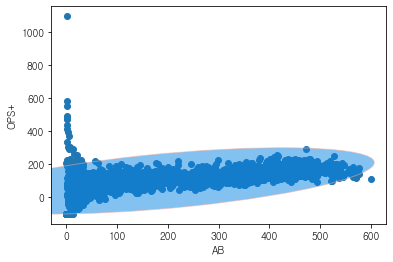

In [29]:
_, outlier_indices = mahalanobis_dist_outlier(train, targets=['AB', 'OPS+'], q=0.95)

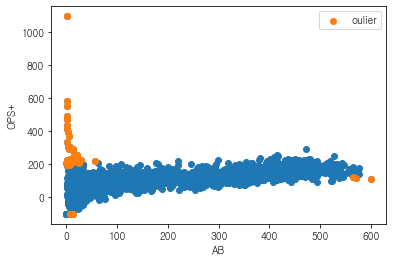

In [30]:
train_outlier = train.loc[train.index.isin(outlier_indices)]

plt.figure()
plt.scatter(train['AB'], train['OPS+'])
plt.scatter(train_outlier['AB'], train_outlier['OPS+'], label='oulier')
plt.legend()
plt.xlabel('AB')
plt.ylabel('OPS+')
plt.show();

In [31]:
train, outlier_indices = mahalanobis_dist_outlier(train, targets=['AB', 'OPS+'], plot=False)

# 변수 생성

## XBH와 BOB



In [32]:
def xbh_bob(df):
    df['XBH'] = df['HR'] + df['2B'] + df['3B'] # 장타
    df['BOB'] = df['H'] + df['BB'] + df['HBP'] # 출루
    df['XBH/PA'] = ((df['HR'] + df['2B'] + df['3B']) / df['PA']).fillna(0) # 장타
    df['BOB/PA'] = ((df['H'] + df['BB'] + df['HBP']) / df['PA']).fillna(0) # 출루
    return df

train = xbh_bob(train)
test = xbh_bob(test)

## BABIP 

BABIP는 투수 혹은 타자가 순수한 실력 외에 수비/운의 영향을 얼마나 받았는지 가늠할 수 있는 지표로 활발히 사용되고 있다. 이는 투수/타자의 BABIP가 다음과 같은 특성을 갖기 때문이다.

* (1) 투수의 능력에 관계없이 모든 투수는 일정한 수준의 시즌 BABIP를 유지한다. 이 값은 대개 0.280~0.300 사이로 유지된다(메이저리그 기준).
* (2) 타자는 개인의 재능, 능력에 따라서 커리어 내내 비슷한 수준의 BABIP를 유지한다.

여기서 일정한 값을 유지한다는 것이 핵심이다. 즉, 어떤 선발 투수의 BABIP가 4할에 육박한다면, 더 많은 경기를 치를 수록 그 값은 3할 수준으로 회귀할 것이라는 예상이 가능하다. 타자의 경우도 비슷하다.

* 공식: BABIP = (안타-홈런) / (타수-삼진-홈런+희생플라이)

다만 시즌 최종 성적에서 BABIP가 통산 성적 혹은 '일반적인 수준'보다 지나치게 높은 타자라면 이듬해 성적 하락을 강하게 의심해볼 수 있다.



2014년 이명기가 그랬는데, 2014년 BABIP 0.432와 0.368/0.414/0.470의 타율/출루율/장타율을 기록한 뒤 이듬해 BABIP가 0.369로 떨어지면서 0.315/0.368/0.397로 성적이 떨어졌다. 홈런 증가 없이 고타율&고BABIP에 기대 성적을 내면 다음해 성적이 떨어진다는 대표적인 사례.

In [33]:
def BABIP(df):
    df['BABIP'] = (df['H'] - df['HR']) / (df['AB'] - df['SO'] - df['HR'] + df['SF'])
    df['BABIP'] = df['BABIP'].fillna(0)
    # df['BABIP*HR'] = df['BABIP'] * (df['2B'] + df['3B'] + df['HR'])
    return df

train = BABIP(train)
test = BABIP(test)

## GPA

GPA는 애런 글리만이 고안한 지표로써 Gross Production Average의 앞 글자를 따서 만들어진 기록이다. OPS의 단점 중 하나인 출루율과 장타율의 비중을 1:1로 두는 문제를 해결하기 위해 출루율에 가중치를 둔 지표이다.

KBO 리그에서는 출루율이 장타율보다 1.57배 중요하다. (장타의 가치가 메이저리그보다 더 높다.) 이는 장타력을 가진 타자가 한국에 더 희소하기 때문으로 해석될 수 있다. 한국형 GPA를 산출하는 공식은 다음과 같다.

GPA = (1.57*(출루율)+장타율)/4

In [34]:
def GPA(df):
    df['GPA'] = (1.57 * df['OBP']) + df['SLG'] / 4
    return df

train = GPA(train)
test = GPA(test)

## RC

득점 생산력

계산 방법이 매우 복잡하다.

A(On baseball factor 출루능력) = 안타+볼넷-도루실패+사구-병살타

B(Advanced factor 진루능력) = 0.24×(볼넷-고의4구+사구)+0.62×도루+0.5×(희생번트+희생플라이)-0.03×삼진

C(Opportunity factor 주어진 기회) = 타수+볼넷+사구+희생번트+희생플라이로 정의할 때,

 

RC = {(2.4C+A)×(3C+B)/(9×C)}-0.9×C이다.

In [35]:
def RC(df):
    # 출루능력
    df['OBF'] = df['H'] + df['BB'] - df['CS'] + df['HBP'] - df['GDP']
    # 진루능력
    df['AF'] = 0.24 * (df['BB'] - df['IBB'] + df['HBP']) + 0.62 * df['SB'] + 0.5 * (df['SH'] + df['SF']) - 0.03 * df['SO']
    # 기회
    df['OF'] = df['AB'] + df['BB'] + df['HBP'] + df['SH'] + df['SF']
    df['RC'] = ((2.4 * df['OF'] + df['OBF']) * (3 * df['OF'] + df['AF']) / 9 * df['OF']) - 0.9 * df['OF']
    df['RC27'] = df['RC'] / 27
    return df

train = RC(train)
test = RC(test)

## XR

XR = (0.50×1B) + (0.72×2B) + (1.04×3B) + (1.44×HR) + (0.34×(HBP+BB−IBB)) + (0.25×IBB) + (0.18×SB) + (−0.32×CS) + (−0.090×(AB−H−K) + (−0.098xK) + (−0.37×GIDP) + (0.37 x SF) + (0.04×SH)

In [36]:
def XR(df):
    # 개인 기대득점
    df['XR'] = (
        0.5 * df['1B'] + 0.72 * df['2B'] + 1.04 * df['3B'] + 1.44 * df['HR'] + 0.34 * (df['HBP'] + df['BB'] - df['IBB'])
        + 0.25 * df['IBB'] + 0.18 * df['SB'] - 0.32 * df['CS'] - 0.09 * (df['AB'] - df['H'] - df['SO']) - 0.098 * df['SO']
        - 0.37 * df['GDP'] + 0.37 * df['SF'] + 0.04 * df['SH']
    ) 
    # 팀 기대득점
    df_team = df.groupby(['year', 'team']).sum().reset_index()[['year', 'team', 'XR']]
    df_team = df_team.rename(columns={'XR':'teamXR'})
    df = pd.merge(df, df_team, on=['year', 'team'], how='left')
    # 팀 기대득점 대비 XR
    df['tXR'] = (df['XR'] / df['teamXR']) * 100
    return df

train['1B'] = train['H'] - (train['2B'] + train['3B'] + train['HR'])
test['1B'] = test['H'] - (test['2B'] + test['3B'] + test['HR'])
train = XR(train)
test = XR(test)

## % 지표

In [37]:
def get_data_per_plate(df):
    # 삼진%
    df['SO%'] = df['SO'] / df['PA']
    df['SO%'] = df['SO%'].fillna(0)
    # 볼넷%
    df['BB%'] = df['BB'] / (df['BB'] + df['SF'] + df['SB'])
    df['BB%'] = df['BB%'].fillna(0)
    # 삼진/볼넷%
    df['BB/SO'] = df['BB'] / df['SO']
    df.loc[df['BB/SO'] == np.inf, 'BB/SO'] = 0
    df['BB/SO'] = df['BB/SO'].fillna(0)
    # 순장타율
    df['IsoP'] = (df['2B'] + (df['3B'] * 2) + (df['HR'] * 3)) / df['PA']
    df['IsoP'] = df['IsoP'].fillna(0)
    # 홈런%
    df['HR/PA'] = df['HR'] / df['PA']
    df.loc[df['HR/PA'] == np.inf, 'HR/PA'] = 0
    df['HR/PA'] = df['HR/PA'].fillna(0)
    # 루타 / 안타
    # df['1B/H'] = (df['1B'] / df['H']).fillna(0)
    # df['2B/H'] = (df['2B'] / df['H']).fillna(0)
    # df['3B/H'] = (df['3B'] / df['H']).fillna(0)
    # df['HR/H'] = (df['HR'] / df['H']).fillna(0)
    
    # 루타 / 타석
    df['1B/PA'] = (df['1B'] / df['PA']).fillna(0)
    df['2B/PA'] = (df['2B'] / df['PA']).fillna(0)
    df['3B/PA'] = (df['3B'] / df['PA']).fillna(0)
    df['HR/PA'] = (df['HR'] / df['PA']).fillna(0)
    return df

train = get_data_per_plate(train)
test = get_data_per_plate(test)

## 범주형 데이터 처리

### 포지션(야수, 포수, 지명타자)

In [38]:
def position(x):
    if x == '내야수' or x == '외야수':
        return 'F'
    elif x == '지명타자':
        return 'D'
    elif x == '포수':
        return 'C'

train['in_out_catcher'] = train['in_out_catcher'].apply(position)

In [39]:
train = pd.concat([train, 
                   pd.get_dummies(train['in_out_catcher'])],
                   axis=1)

### 팀

In [40]:
train = pd.concat([train, 
                   pd.get_dummies(train['team'])],
                   axis=1)

## Aging Curve

In [41]:
from scipy import optimize

def aging_curve(func, df, target='WAR', lower=0.1, upper=0.9, plot=True,
                median=False, ma=False, window=3, opt_return=False,
                age_upper=99, data=True, curve_fit=True):
    
    df = df.loc[(df[target] > df[target].quantile(lower)) &
                (df[target] < df[target].quantile(upper)) &
                (df['age'] < age_upper)]
    if median:
        df_age = df.groupby('age').median().reset_index()
    else:
        df_age = df.groupby('age').mean().reset_index()
    
    if ma:
        title = 'Aging Curve MA(' + target + ')'
        xdata = df_age['age'].rolling(window=window).mean().dropna()
        ydata = df_age[target].rolling(window=window).mean().dropna()
    else:
        title = 'Aging Curve (' + target + ')' 
        xdata = df_age['age']
        ydata = df_age[target]
        
    popt, pcov = optimize.curve_fit(func, xdata, ydata)
    
    if plot:
        plt.figure(figsize=(10, 6))
        if data:
            plt.plot(xdata, ydata, '-o', label='avg. '+ target, color='tab:blue')
        if curve_fit:
            plt.plot(xdata, func(xdata, *popt), '-o', label=title, color='tab:orange')
        plt.xticks(ticks=xdata)
        plt.legend()
        plt.xlabel('Age')
        plt.ylabel(target)
        plt.title(title)
        plt.show();

    if opt_return:
        y_hat = func(xdata, *popt)
        return {x:y for x, y in zip(xdata, y_hat)}

def func(x, a, b, c, d, e):
    return a * x ** 5 + b * x ** 4 + c * x ** 3 + d * x + e

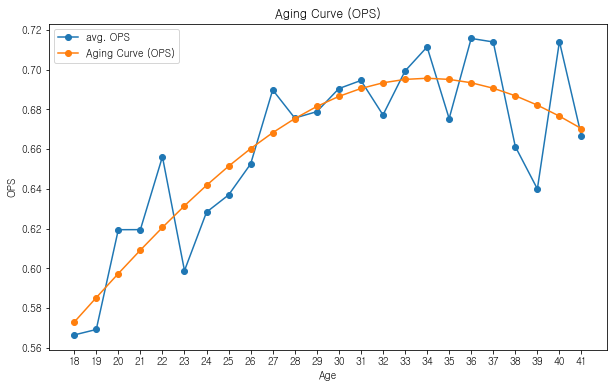

In [42]:
result = aging_curve(func, train, target='OPS', opt_return=True)

# 시즌별 기록 보정

In [43]:
columns = ['age', 'G', 'E', 'PA', 'AB', 'R', 'H', '2B', '3B',
           'HR', 'TB', 'RBI', 'SB', 'CS', 'BB', 'HBP', 'IBB', 'SO', 'GDP', 'SH',
           'SF', 'avg', 'OBP', 'SLG', 'OPS', 'wOBA', 'wRC', 'WAR', 'OPS+', 'BABIP',
           'GPA', 'OBF', 'AF', 'OF', 'RC', 'RC27', '1B', 'XR', 'teamXR', 'tXR',
           'SO%', 'BB%', 'BB/SO', 'IsoP', 'HR/PA', '1B/H', '2B/H', '3B/H', 'HR/H',
           '1B/PA', '2B/PA', '3B/PA']

for year in sorted(train.year.unique()):
    avg_year = train.loc[train['year'] == year][columns].mean()
    train.loc[train['year'] == year, columns] = train[columns] / avg_year

# Data Labeling


  전 시즌 데이터로 다음 시즌 OPS를 예측하도록 데이터 라벨링을 시행한다.

In [44]:
def create_labeling(data, target_name='OPS'):
    data = data.sort_values(['batter_id', 'year']).reset_index(drop=True)
    # 성적 보정 (성적 / 시즌 평균)
    
    # 다음 시즌
    target = list(data[target_name])
    del target[0] 
    target.append(-1)
    data['t_' + target_name] = target
    
    # 타자 이름별 연도가 가장 큰 열의 OPS값을 -1로 바꿔준다.
    # 현역일 경우 2018년, 은퇴한 선수일 경우 은퇴년도가 -1이 된다.
    batter_year = data.groupby('batter_name')['year'].max().reset_index()
    for batter_name, year in zip(list(batter_year['batter_name']), list(batter_year['year'])):
        data.loc[(data['batter_name'] == batter_name) & (data['year'] == year), 't_' + target_name] = -1
    return data

target_name = 't_OPS'
train = create_labeling(train, target_name='OPS')
retire = train.loc[train[target_name] == -1]
train = train.loc[train[target_name] != -1].reset_index(drop=True)
test[target_name] = -1